In [1]:
import matplotlib.pyplot as plt, argparse, numpy as np, math, sys, copy
from skimage.segmentation import slic, mark_boundaries
from skimage.util import img_as_float
from skimage import io
from collections import defaultdict
import SPHC as sphc

In [102]:
imagePath = 'images/face2.jpg'

#SLIC Parameters:
numSegments = 500  # How many superpixels to start with - input for SLIC function
Sigma = 2 # This parameter controls superpixel shape. Higher values make superpixels more square.

#SPHC Parameters:
segmentsToMerge = [20, 90] #[100, 200, 300, 400, 480] #3 # How many superpixels to merge based on color similarity
distance_limit = 1 # Limits which segments get merged based on their difference in average color

In [103]:
image = img_as_float(io.imread(imagePath))
#SLICsegm_grid = slic(image, n_segments = numSegments, sigma = 0, slic_zero = True)
SLICsegm_grid = slic(image, slic_zero = True)

In [104]:
SPHCsegm_grid = sphc.getSPHCsegmentsVect(SLICsegm_grid
                                         , image
                                         , numToMerge = segmentsToMerge
                                         , max_dist = distance_limit)

Initiating Segment Attributes...
Merging Segments...
91 segments merged - final


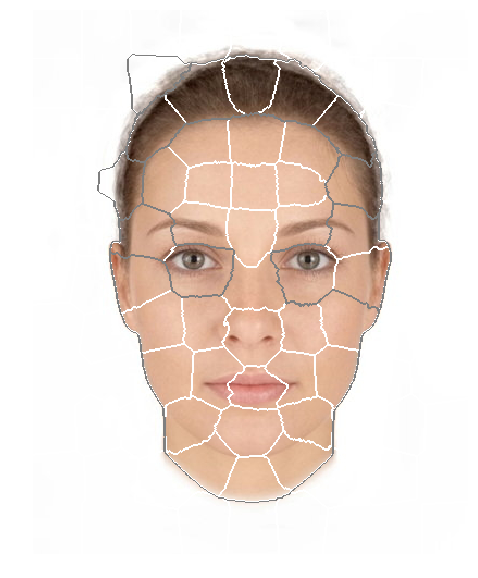

In [105]:
fig = plt.figure("Segments", figsize = (10,10))
ax = fig.add_subplot(1,1,1)

cp_image = image.copy()

i = 1
for segs in SPHCsegm_grid: 
    cp_image = mark_boundaries(cp_image, segs, color=(1/i,1/i,1/i))
    i+=1

ax.imshow(cp_image)
plt.axis("off")
plt.show()